In [1]:
import numpy as np
import os

import os

# Base path where your data resides, relative to your code directory
base_data_path = os.path.join("..", "data")

# Define file names
decode_input_file = "decode_input.txt"
train_struct_file = "train_struct.txt"
model_file = "model.txt"
train_data_file = "train.txt"
test_data_file = "test.txt"
parameter_file = "Parameters"

# Build full paths by appending file names to the base data path
decode_input_path = os.path.join(base_data_path, decode_input_file)
train_struct_path = os.path.join(base_data_path, train_struct_file)
model_path = os.path.join(base_data_path, model_file)
train_data_path = os.path.join(base_data_path, train_data_file)
test_data_path = os.path.join(base_data_path, test_data_file)
parameter_path = os.path.join("..", "results", parameter_file)

# Now you can use these paths in your code
print("File paths:")
print("Decode input path:", decode_input_path)
print("Train struct path:", train_struct_path)
print("Model path:", model_path)
print("Train data path:", train_data_path)
print("Test data path:", test_data_path)



def read_decode_input(file_path = decode_input_path):
    """
    Reads the decode_input data from the file.
    Each line represents one letter with 128 elements.
    There are 26 weight vectors each with 128 elements and a transition matrix T with size 26x26.
    The transition matrix T is in row-major order.
    """
    with open(file_path, "r") as f:
        raw_data = f.read().split("\n")

    X = np.array(raw_data[:100 * 128], dtype=float).reshape(100, 128)
    W = np.array(raw_data[100 * 128:100 * 128 + 26 * 128], dtype=float).reshape(26, 128)
    T = np.array(raw_data[100 * 128 + 26 * 128:-1], dtype=float).reshape(26, 26)
    T = np.swapaxes(T, 0, 1)
    
    print("Shapes of decode input:")
    print("X:", X.shape, "W:", W.shape, "T:", T.shape)
    #print("Top 5 rows of X:\n", X[:5])

    return X, W, T

def read_train_struct(file_path = train_struct_path):
    """
    Reads the train_struct data from the file.
    Each line represents a label and a feature vector (in a sparse representation).
    """
    with open(file_path, "r") as f:
        raw_data = f.read().split("\n")

    dataX, dataY = [], []
    for line in raw_data[:-1]:  # The last element is empty
        line = line.split(" ")
        dataY.append([int(line[0]) - 1, int(line[1][4:])])
        datax = np.zeros(128, dtype=int)
        for f1 in line[2:]:
            idx, val = f1.split(":")
            datax[int(idx) - 1] = int(val)
        dataX.append(datax)
    
    dataX_np = np.array(dataX, dtype=int)
    print("Shapes of train_struct:")
    print("dataX:", dataX_np.shape, "dataY length:", len(dataY))
    #print("Top 5 rows of dataX:\n", dataX_np[:5])
    
    return dataX_np, dataY

def read_model(file_path = model_path):
    """
    Reads the model data from the file.
    The data consists of weight vectors for each label and a transition matrix T.
    """
    with open(file_path, "r") as f:
        raw_data = f.read().split("\n")

    W = np.array(raw_data[:26 * 128], dtype=float).reshape(26, 128)
    T = np.array(raw_data[26 * 128:-1], dtype=float).reshape(26, 26)
    T = np.swapaxes(T, 0, 1)
    
    print("Shapes of model data:")
    print("W:", W.shape, "T:", T.shape)
    #print("Top 5 rows of W:\n", W[:5])
    
    return W, T

def read_train(file_path = train_data_path):
    """
    Read the training data from the file.
    Each row corresponds to an example and is split into the label and the feature vector.
    """
    from string import ascii_lowercase
    mapping = {letter: idx for idx, letter in enumerate(ascii_lowercase)}

    with open(file_path, "r") as f:
        raw_data = f.read().split("\n")

    dataX, dataY = [], []
    tempX, tempY = [], []
    for row in raw_data[:-1]:
        row = row.split(" ")
        tempY.append(mapping[row[1]])
        tempX.append(np.array(row[5:], dtype=float))
        if int(row[2]) < 0:  # End of sequence
            dataX.append(np.array(tempX))
            dataY.append(np.array(tempY, dtype=int))
            tempX, tempY = [], []  # Reset for the next sequence

    print("Number of training sequences:", len(dataX))
    print("First 5 sequences' labels:\n", dataY[:5])
    
    return list(zip(dataX, dataY))

import numpy as np

def read_test(file_path = test_data_path):
    """
    Reads the test data from the file.
    Each row corresponds to an example and is split into the label and the feature vector.
    The function assumes that each example ends when a row with the third column less than 0 is encountered.
    """
    from string import ascii_lowercase
    mapping = {letter: idx for idx, letter in enumerate(ascii_lowercase)}

    with open(file_path, "r") as f:
        raw_data = f.read().split("\n")

    dataX, dataY = [], []
    tempX, tempY = [], []
    for row in raw_data[:-1]:  # Skip the last empty line if it exists
        row = row.split(" ")
        tempY.append(mapping[row[1]])
        tempX.append(np.array(row[5:], dtype=float))
        if int(row[2]) < 0:  # Check for the end of a sequence
            dataX.append(np.array(tempX))
            dataY.append(np.array(tempY, dtype=int))
            tempX, tempY = [], []  # Reset for the next sequence

    print("Number of test sequences:", len(dataX))
    print("First 5 sequences' labels:\n", dataY[:5])

    return list(zip(dataX, dataY))

def read_test_decoder_modified(file_path = test_data_path):
    """
    Reads the test data for decoding and returns a NumPy array
    where each sub-array from the list becomes a row in the final
    two-dimensional array. This function only extracts the features
    and does not deal with the labels.
    """
    with open(file_path, 'r') as file:
        raw_data = file.read().strip().split('\n')

    # Initialize an empty list to store all feature vectors
    dataX = []
    
    for row in raw_data:
        if row:  # Skip any empty lines
            features = row.split(' ')[5:]  # Features start from the 6th element in the row
            feature_vector = list(map(float, features))  # Convert string features to float
            dataX.append(feature_vector)

    # Convert the list of lists (features for each word) into a 2D NumPy array
    dataX_np = np.array(dataX)

    print("Shape of test data for decoder:", dataX_np.shape)
    print("Top 5 feature vectors:\n", dataX_np[:5, :])

    return dataX_np

File paths:
Decode input path: ..\data\decode_input.txt
Train struct path: ..\data\train_struct.txt
Model path: ..\data\model.txt
Train data path: ..\data\train.txt
Test data path: ..\data\test.txt


In [2]:
import math
import numpy as np


def compute_log_p(X, y, W, T):
    """
    Computes the log probability of a sequence of labels given inputs X and parameters W, T.
    
    Parameters:
    X : 2D array where each row is the feature vector for one observation.
    y : 1D array of labels corresponding to the observations in X.
    W : Weight matrix where each row corresponds to the weights for one label.
    T : Transition matrix where T[i, j] is the transition weight from label i to label j.
    
    Returns:
    log probability of the label sequence given the inputs and parameters.
    """

    alpha_len = 26  # Alphabet size; ideally passed as a parameter for flexibility
    
    # Initialize the sum of numerator terms for log probability calculation
    sum_num = numpy.dot(W[y[0]], X[0])  # Initial state score
    for i in range(1, X.shape[0]):
        # Add scores for observed states and transitions
        sum_num += numpy.dot(W[y[i]], X[i]) + T[y[i-1], y[i]]
    
    # Initialize the forward trellis for dynamic programming
    trellisfw = numpy.zeros((X.shape[0], alpha_len))
    # Temporary storage for computations at each step
    interior = numpy.zeros(alpha_len)
    # Messages used in the forward pass for dynamic programming
    messages = numpy.zeros((26, 26))

    # Compute forward messages
    for i in range(1, X.shape[0]):
        # Compute interior scores based on current observation and previous states
        numpy.matmul(W, X[i-1], out=interior)
        numpy.add(interior, trellisfw[i-1], out=interior)
        # Compute messages for all transitions
        numpy.add(T, interior[:, numpy.newaxis], out=messages)
        # Normalize to avoid numerical instability
        maxes = messages.max(axis=0)
        numpy.add(messages, -1*maxes, out=messages)
        numpy.exp(messages, out=messages)
        # Sum messages to compute new state values
        numpy.sum(messages, axis=0, out=interior)
        numpy.log(interior, out=interior)
        # Update trellis with log-sums
        numpy.add(maxes, interior, out=trellisfw[i])

    # Compute final scores
    dots = numpy.matmul(W, X[-1])
    numpy.add(dots, trellisfw[-1], out=interior)

    # Normalize final log-sum to prevent underflow
    M = numpy.max(interior)
    numpy.add(interior, -1*M, out=interior)
    numpy.exp(interior, out=interior)
    
    # Calculate log partition function (log Z)
    log_z = M + math.log(numpy.sum(interior))

    # Return the log probability as difference of scores and log partition function
    return sum_num - log_z

import numpy as np
import math

def fb_prob(X, W, T):
    """
    Forward-backward algorithm to compute probabilities over label sequences.
    
    Parameters:
    - X: Input features for each observation in the sequence. Shape: [sequence_length, num_features]
    - W: Weight matrix for label features. Shape: [num_labels, num_features]
    - T: Transition matrix between labels. Shape: [num_labels, num_labels]
    
    Returns:
    - trellisfw: Forward probabilities. Shape: [sequence_length, num_labels]
    - trellisbw: Backward probabilities. Shape: [sequence_length, num_labels]
    - log_z: Log partition function, scalar.
    """
    sequence_length, num_features = X.shape
    num_labels = W.shape[0]
    
    # Initialize forward and backward trellises
    trellisfw = np.zeros((sequence_length, num_labels))
    trellisbw = np.zeros_like(trellisfw)
    
    # Forward pass
    for i in range(1, sequence_length):
        # Compute the weighted input features for all labels at this step
        weighted_inputs = np.dot(W, X[i-1])
        # Update the trellis with contributions from transitions and previous states
        for j in range(num_labels):
            transition_scores = T[:, j] + trellisfw[i-1]
            trellisfw[i, j] = log_sum_exp(weighted_inputs + transition_scores)
    
    # Backward pass
    trellisbw[-1, :] = 0  # Log-probability of 1 at the end of the sequence
    for i in range(sequence_length - 2, -1, -1):
        # Similar to forward pass but in reverse
        weighted_inputs = np.dot(W, X[i+1])
        for j in range(num_labels):
            transition_scores = T[j, :] + weighted_inputs
            trellisbw[i, j] = log_sum_exp(transition_scores + trellisbw[i+1])
    
    # Compute log partition function using the forward trellis
    final_forward_scores = np.dot(W, X[-1]) + trellisfw[-1]
    log_z = log_sum_exp(final_forward_scores)
    
    return trellisfw, trellisbw, log_z

def log_sum_exp(scores):
    """
    Numerically stable computation of log-sum-exp.
    
    Parameters:
    - scores: Input array of scores to be summed in log-space.
    
    Returns:
    - result: Log-sum-exp of input scores.
    """
    max_score = np.max(scores)
    return max_score + np.log(np.sum(np.exp(scores - max_score)))


# The following functions compute gradients for the weight matrix W and transition matrix T respectively
# given a single example (X, y), where X is the feature matrix for the sequence and y is the corresponding label sequence.

def log_p_wgrad(W, X, y, T):
    """
    Computes the gradient of the log probability with respect to the weight matrix W.
    
    Parameters:
    W : Weight matrix where each row corresponds to the weights for one label.
    X : 2D array where each row is the feature vector for one observation.
    y : 1D array of labels corresponding to the observations in X.
    T : Transition matrix where T[i, j] is the transition weight from label i to label j.
    
    Returns:
    Gradient of the log probability with respect to W.
    """
    grad_W = np.zeros(W.shape)  # Gradient matrix for W
    trellisfw, trellisbw, log_z = fb_prob(X, W, T)

    # Iterate over the sequence
    for i in range(X.shape[0]):
        # Combine forward and backward messages
        marginal = trellisfw[i] + trellisbw[i]
        # Incorporate the evidence from input features
        evidence = np.matmul(W, X[i])
        # Subtract the log partition function
        marginal -= log_z
        # Normalize to get probabilities
        marginal = np.exp(marginal)

        # Calculate the gradient for the current position
        for j in range(26):  # Iterate over all possible labels
            if j == y[i]:
                grad_W[j] += X[i]  # Add the feature vector for the true label
            grad_W[j] -= marginal[j] * X[i]  # Subtract the expected feature vector

    return grad_W


def log_p_tgrad(T, X, y, W):
    """
    Computes the gradient of the log probability with respect to the transition matrix T.
    
    Parameters:
    - T: Transition matrix where T[i, j] is the transition weight from label i to label j.
    - X: 2D array where each row is the feature vector for one observation.
    - y: 1D array of labels corresponding to the observations in X.
    - W: Weight matrix where each row corresponds to the weights for one label.
    
    Returns:
    - grad: Gradient of the log probability with respect to T.
    """
    num_labels = T.shape[0]
    grad = np.zeros_like(T)  # Initialize the gradient matrix for T with zeros
    
    # Compute the forward and backward probabilities and the log partition function (log Z)
    trellisfw, trellisbw, log_z = fb_prob(X, W, T)

    for i in range(X.shape[0] - 1):
        potential = np.zeros_like(T)  # Potential for transitions
        
        # Calculate potential scores for transitions considering features and transition scores
        for j in range(num_labels):
            for k in range(num_labels):
                potential[j, k] = np.dot(W[j], X[i]) + np.dot(W[k], X[i+1]) + T[j, k]
        
        potential += trellisfw[i][:, np.newaxis] + trellisbw[i+1]
        potential -= log_z  # Normalize by subtracting log partition function
        potential = np.exp(potential)  # Convert to probabilities
        
        # Update the gradient
        grad[y[i], y[i+1]] += 1  # Increment gradient for observed transition
        grad -= potential  # Subtract expected transition probabilities
        
    return grad



# Example usage:
# Assuming X, y, W, and T are already loaded
# grad_W = log_p_wgrad(W, X, y, T)
# grad_T = log_p_tgrad(T, X, y, W)
# The gradients are used in optimization algorithm to update W and T


**To tackle question 4a, let's follow a systematic approach. We'll implement stochastic optimization using SGD, SGD with momentum, and compare them with LBFGS.** We'll need to:

Implement the function to compute the training objective (negative log-likelihood).

Implement the callback function for LBFGS to track the progress.

Implement SGD and SGD with momentum for stochastic optimization.

Tune hyperparameters for SGD, momentum, and LBFGS.

Plot the training objective and test error over effective passes for comparison.

In [31]:
import numpy as np
import os

# Parameters (set to default values, tentative for fine-tuning)
C = 1000.0  # Regularization parameter
B = 128  # Mini-batch size for SGD and momentum
learning_rate = 0.01  # Learning rate for SGD and momentum
momentum_gamma = 0.9  # Momentum coefficient for SGD with momentum
num_epochs = 10  # Number of epochs for SGD and momentum

# Read in the data
X, W, T = read_decode_input(decode_input_path)
trainX, trainY = read_train_struct(train_struct_path)
W_model, T_model = read_model(model_path)
train_data = read_train(train_data_path)
test_data = read_test(test_data_path)

# Calculating the number of training and test examples
num_train_examples = sum(len(sequence[0]) for sequence in train_data)
num_test_examples = sum(len(sequence[0]) for sequence in test_data)
num_features = 128  # Number of features for each observation
num_classes = 26  # Number of classes/labels

# Debug prints
print(f'Number of training examples: {num_train_examples}')
print(f'Number of test examples: {num_test_examples}')

Shapes of decode input:
X: (100, 128) W: (26, 128) T: (26, 26)
Shapes of train_struct:
dataX: (25953, 128) dataY length: 25953
Shapes of model data:
W: (26, 128) T: (26, 26)
Number of training sequences: 3438
First 5 sequences' labels:
 [array([ 0, 10,  4]), array([14, 12, 12,  0, 13,  3,  8, 13,  6]), array([ 4, 17, 14]), array([13,  4, 23, 15,  4,  2, 19,  4,  3]), array([ 4,  2, 11,  0, 17,  8, 13,  6])]
Number of test sequences: 3439
First 5 sequences' labels:
 [array([24, 11, 14, 15,  7, 14, 13,  4]), array([13, 22, 14, 17, 10,  0,  1, 11,  4]), array([ 2,  2, 14, 20, 13, 19,  0,  1,  8, 11,  8, 19, 24]), array([17,  8,  6,  7, 19,  5, 20, 11, 11, 24]), array([ 4,  2, 14, 12, 15, 17,  4, 18, 18])]
Number of training examples: 25953
Number of test examples: 26198


In [62]:
def log_sum_exp(vector):
    """Computes the log of the sum of exponentials of input elements."""
    a = np.max(vector)
    return a + np.log(np.sum(np.exp(vector - a)))


def forward_pass(X, T, W):
    """
    Perform the forward pass to compute alpha values.
    :param X: Observations/features for a sequence
    :param T: Transition matrix
    :param W: Weight matrix
    :return: Alpha values
    """
    
    """Compute alpha values in log space to avoid numerical instability."""
    num_nodes, num_classes = len(X), T.shape[0]
    log_alpha = np.zeros((num_nodes, num_classes))
    log_T = np.log(T + 1e-10)

    # Initialize with the first observation
    log_alpha[0] = np.log(np.exp(W @ X[0]) + 1e-10)

    # Induction
    for k in range(1, num_nodes):
        for y_next in range(num_classes):
            log_alpha[k, y_next] = log_sum_exp(log_alpha[k-1] + log_T[:, y_next] + (W @ X[k]))

    return log_alpha


def backward_pass(X, T, W):
    """
    Perform the backward pass to compute beta values.
    :param X: Observations/features for a sequence
    :param T: Transition matrix
    :param W: Weight matrix
    :return: Beta values
    """
    num_nodes, num_classes = len(X), T.shape[0]
    beta = np.zeros((num_nodes, num_classes))
    
    # Initialization
    beta[-1] = np.ones(num_classes)  # All ones for the last node
    
    # Induction
    for k in range(num_nodes - 2, -1, -1):
        for y_prev in range(num_classes):
            beta[k, y_prev] = np.sum(beta[k+1] * T[y_prev, :] * np.exp(W @ X[k+1]))
        beta[k] /= np.sum(beta[k])  # Normalize
    
    return beta

def compute_likelihood(X, y, W, T, alpha, beta):
    """
    Compute the likelihood of the label sequence given the observations.

    :param X: Observations/features for a sequence
    :param y: Labels for a sequence
    :param W: Weight matrix
    :param T: Transition matrix
    :param alpha: Alpha values from the forward pass
    :param beta: Beta values from the backward pass
    :return: The likelihood of the label sequence given the observations
    """
    num_nodes = len(X)
    Z = np.sum(alpha[-1])  # Partition function from the last alpha values

    # Compute the joint probability of y and X
    joint_prob = 1.0
    for k in range(num_nodes):
        if k == 0:
            joint_prob *= alpha[k, y[k]]
        else:
            joint_prob *= alpha[k-1, y[k-1]] * T[y[k-1], y[k]] * np.exp(W @ X[k])
    
    # Divide joint probability by partition function to get conditional probability
    p_y_given_X = joint_prob / Z

    return p_y_given_X

def compute_objective(W, T, train_data, C):
    """
    Compute the negative log-likelihood objective for CRF.

    :param W: Weight matrix of shape (num_classes, num_features)
    :param T: Transition matrix of shape (num_classes, num_classes)
    :param train_data: List of training examples, where each example is a tuple (X, y)
    :param C: Regularization parameter
    :return: The negative log-likelihood objective value.
    """
    objective = 0.0
    for X, y in train_data:
        alpha = forward_pass(X, T, W)
        beta = backward_pass(X, T, W)
        p_y_given_X = compute_likelihood(X, y, W, T, alpha, beta) + 1e-10
        try:
            objective -= np.log(p_y_given_X)
        except ValueError:
            print(f"Error computing log for p_y_given_X: {p_y_given_X}")
            continue  # Skip this iteration for debugging purposes

    regularization = C * (np.linalg.norm(W)**2 + np.linalg.norm(T)**2)
    objective += regularization
    try:
        return objective.item()
    except ValueError as e:
        print(f"Objective computation error: {e}")
        return np.nan  # Return NaN to indicate failure



def compute_gradients(W, T, mini_batch, C):
    """
    Compute gradients for the weights W and transitions T over a mini-batch.
    
    Parameters:
    W : Weight matrix where each row corresponds to the weights for one label.
    T : Transition matrix where T[i, j] is the transition weight from label i to label j.
    mini_batch : A mini-batch of training examples.
    C : Regularization strength.
    
    Returns:
    W_gradient : Gradient matrix for W.
    T_gradient : Gradient matrix for T.
    """
    W_gradient = np.zeros_like(W)
    T_gradient = np.zeros_like(T)

    # Sum gradients over all examples in the mini-batch
    for X, y in mini_batch:
        W_gradient += log_p_wgrad(W, X, y, T)
        T_gradient += log_p_tgrad(T, X, y, W)
    
    # Average the gradients and add regularization
    W_gradient /= len(mini_batch)
    W_gradient -= 2 * C * W  # L2 regularization
    T_gradient /= len(mini_batch)
    T_gradient -= 2 * C * T  # L2 regularization
    
    return W_gradient, T_gradient

def predict_sequence(X, W, T):
    _, trellisfw, log_z = fb_prob(X, W, T)
    y_pred = np.argmax(trellisfw, axis=1)  # Predicted labels
    return y_pred

def compute_error_rate(X_test, y_test, W, T):
    errors = 0
    for X, y_true in zip(X_test, y_test):
        y_pred = predict_sequence(X, W, T)
        errors += np.mean(y_pred != y_true)
    return errors / len(X_test)



In [33]:
import matplotlib.pyplot as plt

def test_error(W, T, test_data):
    """
    Compute the label-wise error rate on the test data.
    :param W: Weight matrix of shape (num_classes, num_features)
    :param T: Transition matrix of shape (num_classes, num_classes)
    :param test_data: List of test examples, where each example is a tuple (X, y)
    :return: The label-wise error rate.
    """
    errors = 0
    total_labels = 0

    for X, y in test_data:
        alpha = forward_pass(X, T, W)
        y_pred = np.argmax(alpha, axis=1)  # Predict the label with the highest probability at each step
        errors += np.sum(y_pred != y)
        total_labels += len(y)
    
    return errors / total_labels


# Callback function for LBFGS
def lbfgs_callback(xk):
    global function_evals_counter, lbfgs_objective_values, lbfgs_test_errors
    
    # Reshape xk into W and T matrices
    W = xk[:num_classes * num_features].reshape(num_classes, num_features)
    T = xk[num_classes * num_features:].reshape(num_classes, num_classes)
    
    # Compute current objective value
    current_objective = compute_objective(W, T, train_data, C)
    lbfgs_objective_values.append(current_objective)
    
    # Compute and log the error rate
    err_rate = compute_error_rate(X_test, y_test, W, T)
    lbfgs_test_errors.append(err_rate)
    
    # Increase the counter by 1 and print progress
    function_evals_counter += 1
    print(f"Iteration {function_evals_counter}: Objective = {current_objective}, Test Error = {current_test_error}")
    
    # Optionally, save checkpoint of W and T

# Optionally, define a function to plot the progress over time
def plot_progress(lbfgs_objective_values, lbfgs_test_errors):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(lbfgs_objective_values, label='Objective value')
    plt.title('Objective value over iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Objective value')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(lbfgs_test_errors, label='Test error')
    plt.title('Test error over iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Test error')
    plt.legend()plt.label('Test')

    plt.tight_layout()
    plt.show()

# Run optimization algorithm with L-BFGS, callback function will be used to track progress
# ...

# After optimization, plot the progress
#plot_progress(lbfgs_objective_values, lbfgs_test_errors)


SyntaxError: unterminated string literal (detected at line 60) (2091655782.py, line 60)

In [ ]:
def sgd(train_data, num_epochs, B, learning_rate, W, T):
    for epoch in range(num_epochs):
        np.random.shuffle(train_data)
        for i in range(0, len(train_data), B):
            mini_batch = train_data[i:i+B]
            grad_W_total = np.zeros_like(W)
            grad_T_total = np.zeros_like(T)

            # Compute gradient for mini-batch
            for X, y in mini_batch:
                grad_W = log_p_wgrad(W, X, y, T)
                grad_T = log_p_tgrad(T, X, y, W)
                grad_W_total += grad_W
                grad_T_total += grad_T
            
            # Update the parameters
            W += learning_rate * (grad_W_total / B)
            T += learning_rate * (grad_T_total / B)
            
    return W, T


def sgd_momentum(train_data, num_epochs, B, learning_rate, momentum_gamma, W, T):
    v_W = np.zeros_like(W)
    v_T = np.zeros_like(T)

    for epoch in range(num_epochs):
        np.random.shuffle(train_data)
        for i in range(0, len(train_data), B):
            mini_batch = train_data[i:i+B]
            grad_W_total = np.zeros_like(W)
            grad_T_total = np.zeros_like(T)

            # Compute gradient for mini-batch
            for X, y in mini_batch:
                grad_W = log_p_wgrad(W, X, y, T)
                grad_T = log_p_tgrad(T, X, y, W)
                grad_W_total += grad_W
                grad_T_total += grad_T

            # Apply momentum updates
            v_W = momentum_gamma * v_W - learning_rate * (grad_W_total / B)
            v_T = momentum_gamma * v_T - learning_rate * (grad_T_total / B)
            
            W += v_W
            T += v_T
            
    return W, T


In [34]:
def check_numerical_stability(W, T, X):
    """Check for NaN or infinity in the parameters or data."""
    if np.isnan(W).any() or np.isinf(W).any():
        print("Numerical instability in W.")
    if np.isnan(T).any() or np.isinf(T).any():
        print("Numerical instability in T.")
    for x in X:
        if np.isnan(x).any() or np.isinf(x).any():
            print("Numerical instability in input data.")
            
check_numerical_stability(W,T,X)

In [42]:
# Call the optimization functions
W_updated, T_updated = sgd(train_data, num_epochs, B, learning_rate, W, T)

In [19]:
test_err = test_error(W_updated, T_updated, test_data)
print(f'Test Error after SGD: {test_err}')

NameError: name 'W_updated' is not defined

In [44]:
W_updated_momentum, T_updated_momentum = sgd_momentum(train_data, num_epochs, B, learning_rate, momentum_gamma, W, T)

In [45]:
test_err = test_error(W_updated_momentum, T_updated_momentum, test_data)
print(f'Test Error after SGD momentum: {test_err}')

Test Error after SGD momentum: 0.9938544927093671


In [35]:
from scipy.optimize import fmin_l_bfgs_b


def lbfgs_optimize(W, T, train_data, C, maxiter=100):
    # Flatten W and T into a single parameter vector for optimization
    initial_params = np.concatenate([W.flatten(), T.flatten()])
    
    # Define a wrapper for the objective and gradient computation
    def objective_and_grad(params):
        W = params[:num_classes * num_features].reshape(num_classes, num_features)
        T = params[num_classes * num_features:].reshape(num_classes, num_classes)
        obj = compute_objective(W, T, train_data, C)
        grad_W, grad_T = compute_gradients(W, T, train_data, C)
        grad = np.concatenate([grad_W.flatten(), grad_T.flatten()])
        return obj, grad

    # Optimize using L-BFGS
    optimized_params, f, d = fmin_l_bfgs_b(objective_and_grad, initial_params, maxfun=maxiter, callback=lbfgs_callback)
    
    # Reshape the optimized parameters back into W and T
    W_optimized = optimized_params[:num_classes * num_features].reshape(num_classes, num_features)
    T_optimized = optimized_params[num_classes * num_features:].reshape(num_classes, num_classes)
    
    return W_optimized, T_optimized


In [36]:
function_evals_counter = 0
lbfgs_objective_values = []
lbfgs_test_errors = []

# SGD Optimization
sgd_objective_values, sgd_test_errors = [], []
W_sgd, T_sgd = W.copy(), T.copy()  # Create copies to avoid modifying the original parameters
for epoch in range(num_epochs):
    W_sgd, T_sgd = sgd(train_data, 1, B, learning_rate, W_sgd, T_sgd)
    obj = compute_objective(W_sgd, T_sgd, train_data, C)
    err = test_error(W_sgd, T_sgd, test_data)
    sgd_objective_values.append(obj)
    sgd_test_errors.append(err)


KeyboardInterrupt: 

In [40]:
sgd_test_errors

[]

In [ ]:
# SGD with Momentum Optimization
sgd_momentum_objective_values, sgd_momentum_test_errors = [], []
W_momentum, T_momentum = W.copy(), T.copy()
for epoch in range(num_epochs):
    W_momentum, T_momentum = sgd_momentum(train_data, 1, B, learning_rate, momentum_gamma, W_momentum, T_momentum)
    obj = compute_objective(W_momentum, T_momentum, train_data, C)
    err = test_error(W_momentum, T_momentum, test_data)
    sgd_momentum_objective_values.append(obj)
    sgd_momentum_test_errors.append(err)

In [ ]:
sgd_momentum_test_errors

In [29]:
# Flatten W and T for L-BFGS optimization
initial_params = np.concatenate([W.flatten(), T.flatten()])

# Example L-BFGS call (ensure lbfgs_optimize is implemented correctly)
W_lbfgs, T_lbfgs = lbfgs_optimize(W.flatten(), T.flatten(), train_data, C, maxiter=100)

C:\Users\prana\AppData\Local\Temp\ipykernel_3860\1784809121.py:19: RuntimeWarning: invalid value encountered in log
  log_T = np.log(T + 1e-10)


Objective computation error: can only convert an array of size 1 to a Python scalar
Objective computation error: can only convert an array of size 1 to a Python scalar
Objective computation error: can only convert an array of size 1 to a Python scalar
Objective computation error: can only convert an array of size 1 to a Python scalar
Objective computation error: can only convert an array of size 1 to a Python scalar
Objective computation error: can only convert an array of size 1 to a Python scalar
Objective computation error: can only convert an array of size 1 to a Python scalar


C:\Users\prana\AppData\Local\Temp\ipykernel_3860\1784809121.py:22: RuntimeWarning: overflow encountered in exp
  log_alpha[0] = np.log(np.exp(W @ X[0]) + 1e-10)
C:\Users\prana\AppData\Local\Temp\ipykernel_3860\1784809121.py:49: RuntimeWarning: overflow encountered in exp
  beta[k, y_prev] = np.sum(beta[k+1] * T[y_prev, :] * np.exp(W @ X[k+1]))
C:\Users\prana\AppData\Local\Temp\ipykernel_3860\1784809121.py:75: RuntimeWarning: overflow encountered in exp
  joint_prob *= alpha[k-1, y[k-1]] * T[y[k-1], y[k]] * np.exp(W @ X[k])
C:\Users\prana\AppData\Local\Temp\ipykernel_3860\1784809121.py:75: RuntimeWarning: overflow encountered in multiply
  joint_prob *= alpha[k-1, y[k-1]] * T[y[k-1], y[k]] * np.exp(W @ X[k])
C:\Users\prana\AppData\Local\Temp\ipykernel_3860\1784809121.py:75: RuntimeWarning: invalid value encountered in multiply
  joint_prob *= alpha[k-1, y[k-1]] * T[y[k-1], y[k]] * np.exp(W @ X[k])
C:\Users\prana\AppData\Local\Temp\ipykernel_3860\1784809121.py:49: RuntimeWarning: overflo

Objective computation error: can only convert an array of size 1 to a Python scalar
Objective computation error: can only convert an array of size 1 to a Python scalar
Objective computation error: can only convert an array of size 1 to a Python scalar
Objective computation error: can only convert an array of size 1 to a Python scalar
Objective computation error: can only convert an array of size 1 to a Python scalar
Objective computation error: can only convert an array of size 1 to a Python scalar
Objective computation error: can only convert an array of size 1 to a Python scalar
Objective computation error: can only convert an array of size 1 to a Python scalar
Objective computation error: can only convert an array of size 1 to a Python scalar
Objective computation error: can only convert an array of size 1 to a Python scalar
Objective computation error: can only convert an array of size 1 to a Python scalar
Objective computation error: can only convert an array of size 1 to a Python

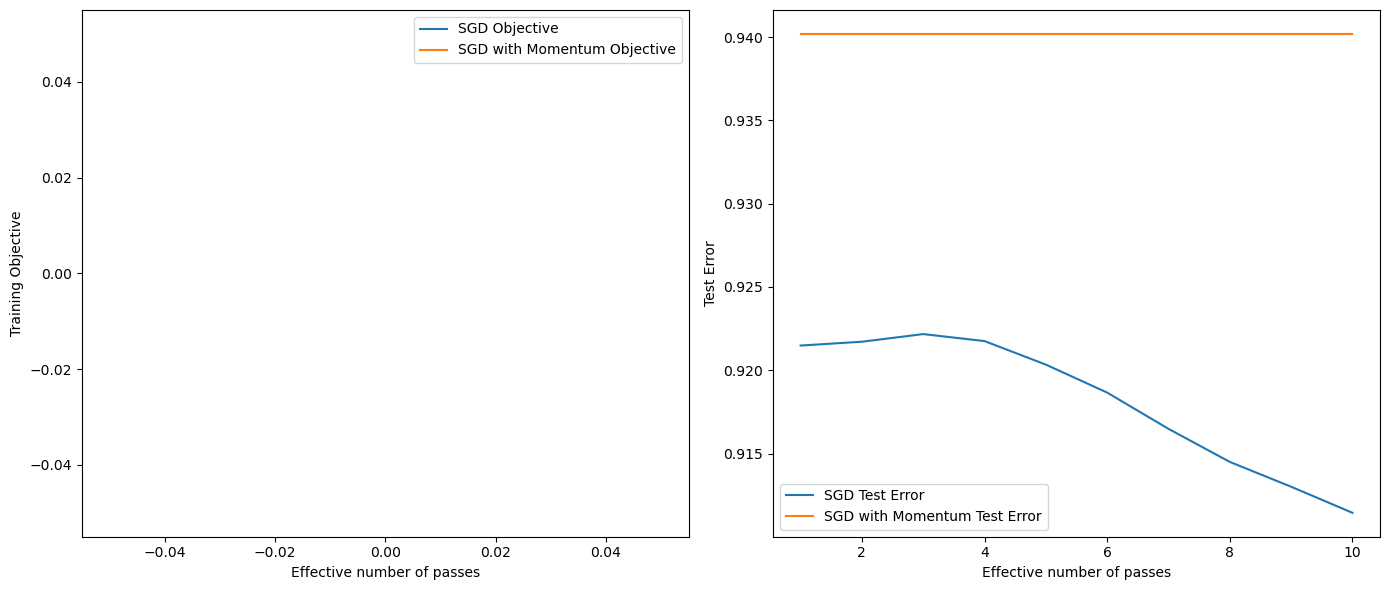

In [30]:
def plot_comparison(sgd_objective_values, sgd_test_errors, sgd_momentum_objective_values, sgd_momentum_test_errors, lbfgs_objective_values, lbfgs_test_errors):
    max_length = max(len(sgd_objective_values), len(sgd_momentum_objective_values), len(lbfgs_objective_values))
    epochs = np.arange(1, max_length + 1)
    plt.figure(figsize=(14, 6))
    
    # Plotting training objective
    plt.subplot(1, 2, 1)
    if sgd_objective_values:
        plt.plot(epochs[:len(sgd_objective_values)], sgd_objective_values, label='SGD Objective')
    if sgd_momentum_objective_values:
        plt.plot(epochs[:len(sgd_momentum_objective_values)], sgd_momentum_objective_values, label='SGD with Momentum Objective')
    if lbfgs_objective_values:
        plt.plot(epochs[:len(lbfgs_objective_values)], lbfgs_objective_values, label='L-BFGS Objective', linestyle='--')
    plt.xlabel('Effective number of passes')
    plt.ylabel('Training Objective')
    plt.legend()
    
    # Plotting test error
    plt.subplot(1, 2, 2)
    if sgd_test_errors:
        plt.plot(epochs[:len(sgd_test_errors)], sgd_test_errors, label='SGD Test Error')
    if sgd_momentum_test_errors:
        plt.plot(epochs[:len(sgd_momentum_test_errors)], sgd_momentum_test_errors, label='SGD with Momentum Test Error')
    if lbfgs_test_errors:
        plt.plot(epochs[:len(lbfgs_test_errors)], lbfgs_test_errors, label='L-BFGS Test Error', linestyle='--')
    plt.xlabel('Effective number of passes')
    plt.ylabel('Test Error')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


plot_comparison(
    sgd_objective_values, sgd_test_errors,
    sgd_momentum_objective_values, sgd_momentum_test_errors,
    lbfgs_objective_values, lbfgs_test_errors
)


In [38]:
def sgd_step(mini_batch, W, T, learning_rate):
    W_grad, T_grad = compute_gradients(W, T, mini_batch, C)
    W -= learning_rate * W_grad
    T -= learning_rate * T_grad
    return W, T


def sgd_momentum_step(mini_batch, W, T, vW, vT, learning_rate, momentum_gamma):
    W_grad, T_grad = compute_gradients(W, T, mini_batch, C)
    vW = momentum_gamma * vW - learning_rate * W_grad
    vT = momentum_gamma * vT - learning_rate * T_grad
    W += vW
    T += vT
    return W, T, vW, vT


In [53]:
def sgd_optimization(train_data, X_test, y_test, W_init, T_init, num_epochs, batch_size, learning_rate):
    W, T = W_init.copy(), T_init.copy()
    sgd_objective_values, sgd_test_errors = [], []
    for epoch in range(num_epochs):
        np.random.shuffle(train_data)
        for i in range(0, len(train_data), batch_size):
            mini_batch = train_data[i:i+batch_size]
            W, T = sgd_step(mini_batch, W, T, learning_rate)  # Implement your sgd_step function
        
        obj = compute_objective(W, T, train_data)  # Implement compute_objective function
        error_rate = compute_error_rate(X_test, y_test, W, T)  # Use your compute_error_rate function
        sgd_objective_values.append(obj)
        sgd_test_errors.append(error_rate)
    
    return W, T, sgd_objective_values, sgd_test_errors


def sgd_momentum_optimization(train_data, X_test, y_test, W_init, T_init, num_epochs, batch_size, learning_rate, momentum):
    W, T = W_init.copy(), T_init.copy()
    vW, vT = np.zeros_like(W), np.zeros_like(T)
    sgd_momentum_objective_values, sgd_momentum_test_errors = [], []
    for epoch in range(num_epochs):
        np.random.shuffle(train_data)
        for i in range(0, len(train_data), batch_size):
            mini_batch = train_data[i:i+batch_size]
            W, T, vW, vT = sgd_momentum_step(mini_batch, W, T, vW, vT, learning_rate, momentum)  # Implement your sgd_momentum_step function
        
        obj = compute_objective(W, T, train_data)  # Implement compute_objective function
        error_rate = compute_error_rate(X_test, y_test, W, T)  # Use your compute_error_rate function
        sgd_momentum_objective_values.append(obj)
        sgd_momentum_test_errors.append(error_rate)
    
    return W, T, sgd_momentum_objective_values, sgd_momentum_test_errors



def lbfgs_optimize(X_test, y_test, W_init, T_init, train_data, maxiter=100):
    initial_params = np.concatenate([W_init.flatten(), T_init.flatten()])
    global lbfgs_objective_values, lbfgs_test_errors

    def objective_and_grad(params):
        W = params[:W_init.size].reshape(W_init.shape)
        T = params[W_init.size:].reshape(T_init.shape)
        obj = compute_objective(W, T, train_data, C)
        grad_W, grad_T = compute_gradients(W, T, train_data, C)  # Implement your compute_gradients function
        grad = np.concatenate([grad_W.flatten(), grad_T.flatten()])
        return obj, grad
    
    def callback(params):
        global function_evals_counter
        W = params[:W_init.size].reshape(W_init.shape)
        T = params[W_init.size:].reshape(T_init.shape)
        obj = compute_objective(W, T, train_data, C)
        error_rate = compute_error_rate(X_test, y_test, W, T)
        lbfgs_objective_values.append(obj)
        lbfgs_test_errors.append(error_rate)
        function_evals_counter += 1

    optimized_params, _, _ = fmin_l_bfgs_b(objective_and_grad, initial_params, maxfun=maxiter, callback=callback)
    W_optimized = optimized_params[:W_init.size].reshape(W_init.shape)
    T_optimized = optimized_params[W_init.size:].reshape(T_init.shape)
    
    return W_optimized, T_optimized, lbfgs_objective_values, lbfgs_test_errors


In [61]:
train_data = read_train(train_data_path)
test_data = read_test(test_data_path)  # test_data is a list of (X, y) tuples 

X_test = [X for X, _ in test_data]
y_test = [y for _, y in test_data]

# Initialize W and T using either read_model() or another appropriate method
W, T = read_model()


function_evals_counter = 0
lbfgs_objective_values = []
lbfgs_test_errors = []

# SGD Optimization
W_sgd, T_sgd = W.copy(), T.copy()  # Create copies to avoid modifying the original parameters

sgd_objective_values, sgd_test_errors = [], []
for epoch in range(num_epochs):
    W, T = sgd_step(train_data, W_sgd, T_sgd, learning_rate)
    # Compute objective and test error for this epoch
    obj = compute_objective(W_sgd, T_sgd, train_data, C)
    test_err = compute_error_rate(X_test, y_test, W_sgd, T_sgd)
    sgd_objective_values.append(obj)
    sgd_test_errors.append(test_err)
    print("ERRORS_______", epoch ," sgd_test_errors: ",test_err,  " |    sgd_objective_values: ", obj)

Number of training sequences: 3438
First 5 sequences' labels:
 [array([ 0, 10,  4]), array([14, 12, 12,  0, 13,  3,  8, 13,  6]), array([ 4, 17, 14]), array([13,  4, 23, 15,  4,  2, 19,  4,  3]), array([ 4,  2, 11,  0, 17,  8, 13,  6])]
Number of test sequences: 3439
First 5 sequences' labels:
 [array([24, 11, 14, 15,  7, 14, 13,  4]), array([13, 22, 14, 17, 10,  0,  1, 11,  4]), array([ 2,  2, 14, 20, 13, 19,  0,  1,  8, 11,  8, 19, 24]), array([17,  8,  6,  7, 19,  5, 20, 11, 11, 24]), array([ 4,  2, 14, 12, 15, 17,  4, 18, 18])]
Shapes of model data:
W: (26, 128) T: (26, 26)


C:\Users\prana\AppData\Local\Temp\ipykernel_3860\2488187648.py:19: RuntimeWarning: invalid value encountered in log
  log_T = np.log(T + 1e-10)


ERRORS_______ 0  sgd_test_errors:  0.9530530154476082  |    sgd_objective_values:  [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan]


KeyboardInterrupt: 

In [47]:
sgd_test_errors

[0.9530530154476082,
 0.9526567565096221,
 0.9526567565096221,
 0.9526567565096221,
 0.9526567565096221,
 0.9526567565096221,
 0.9526567565096221,
 0.9526567565096221,
 0.9526567565096221,
 0.9526567565096221]

In [44]:
# SGD with momentum

vW, vT = np.zeros_like(W), np.zeros_like(T)
for epoch in range(num_epochs):
    np.random.shuffle(train_data)
    for i in range(0, len(train_data), B):
        mini_batch = train_data[i:i+B]
        W_momentum, T_momentum, vW, vT = sgd_momentum_step(mini_batch, W_momentum, T_momentum, vW, vT, learning_rate, momentum_gamma)
    obj = compute_objective(W_momentum, T_momentum, train_data, C)
    test_err = compute_error_rate(X_test, y_test, W_momentum, T_momentum)
    sgd_momentum_objective_values.append(obj)
    sgd_momentum_test_errors.append(test_err)


C:\Users\prana\AppData\Local\Temp\ipykernel_3860\1023438.py:156: RuntimeWarning: overflow encountered in exp
  marginal = np.exp(marginal)
C:\Users\prana\AppData\Local\Temp\ipykernel_3860\1023438.py:162: RuntimeWarning: invalid value encountered in multiply
  grad_W[j] -= marginal[j] * X[i]  # Subtract the expected feature vector
C:\Users\prana\AppData\Local\Temp\ipykernel_3860\1023438.py:152: RuntimeWarning: invalid value encountered in matmul
  evidence = np.matmul(W, X[i])


Objective computation error: can only convert an array of size 1 to a Python scalar
Objective computation error: can only convert an array of size 1 to a Python scalar
Objective computation error: can only convert an array of size 1 to a Python scalar
Objective computation error: can only convert an array of size 1 to a Python scalar
Objective computation error: can only convert an array of size 1 to a Python scalar
Objective computation error: can only convert an array of size 1 to a Python scalar
Objective computation error: can only convert an array of size 1 to a Python scalar
Objective computation error: can only convert an array of size 1 to a Python scalar
Objective computation error: can only convert an array of size 1 to a Python scalar
Objective computation error: can only convert an array of size 1 to a Python scalar


In [46]:
sgd_momentum_test_errors

[0.9401862737613559,
 0.9401862737613559,
 0.9401862737613559,
 0.9401862737613559,
 0.9401862737613559,
 0.9401862737613559,
 0.9401862737613559,
 0.9401862737613559,
 0.9401862737613559,
 0.9401862737613559,
 0.9157183709960666,
 0.9157183709960666,
 0.9157183709960666,
 0.9157183709960666,
 0.9157183709960666,
 0.9157183709960666,
 0.9157183709960666,
 0.9157183709960666,
 0.9157183709960666,
 0.9157183709960666]

In [54]:

# Assuming W_init and T_init are your initial W and T matrices for the optimization process
W_init, T_init = W.copy(), T.copy()
W_lbfgs, T_lbfgs, lbfgs_objective_values, lbfgs_test_errors = lbfgs_optimize( X_test, y_test, W_init, T_init, train_data, maxiter=100)


C:\Users\prana\AppData\Local\Temp\ipykernel_3860\68444693.py:19: RuntimeWarning: invalid value encountered in log
  log_T = np.log(T + 1e-10)
C:\Users\prana\AppData\Local\Temp\ipykernel_3860\68444693.py:22: RuntimeWarning: overflow encountered in exp
  log_alpha[0] = np.log(np.exp(W @ X[0]) + 1e-10)
C:\Users\prana\AppData\Local\Temp\ipykernel_3860\68444693.py:49: RuntimeWarning: overflow encountered in exp
  beta[k, y_prev] = np.sum(beta[k+1] * T[y_prev, :] * np.exp(W @ X[k+1]))
C:\Users\prana\AppData\Local\Temp\ipykernel_3860\68444693.py:75: RuntimeWarning: overflow encountered in exp
  joint_prob *= alpha[k-1, y[k-1]] * T[y[k-1], y[k]] * np.exp(W @ X[k])
C:\Users\prana\AppData\Local\Temp\ipykernel_3860\68444693.py:75: RuntimeWarning: invalid value encountered in multiply
  joint_prob *= alpha[k-1, y[k-1]] * T[y[k-1], y[k]] * np.exp(W @ X[k])


Objective computation error: can only convert an array of size 1 to a Python scalar
Objective computation error: can only convert an array of size 1 to a Python scalar
Objective computation error: can only convert an array of size 1 to a Python scalar
Objective computation error: can only convert an array of size 1 to a Python scalar
Objective computation error: can only convert an array of size 1 to a Python scalar
Objective computation error: can only convert an array of size 1 to a Python scalar
Objective computation error: can only convert an array of size 1 to a Python scalar
Objective computation error: can only convert an array of size 1 to a Python scalar
Objective computation error: can only convert an array of size 1 to a Python scalar
Objective computation error: can only convert an array of size 1 to a Python scalar
Objective computation error: can only convert an array of size 1 to a Python scalar
Objective computation error: can only convert an array of size 1 to a Python

In [57]:
lbfgs_objective_values

[]

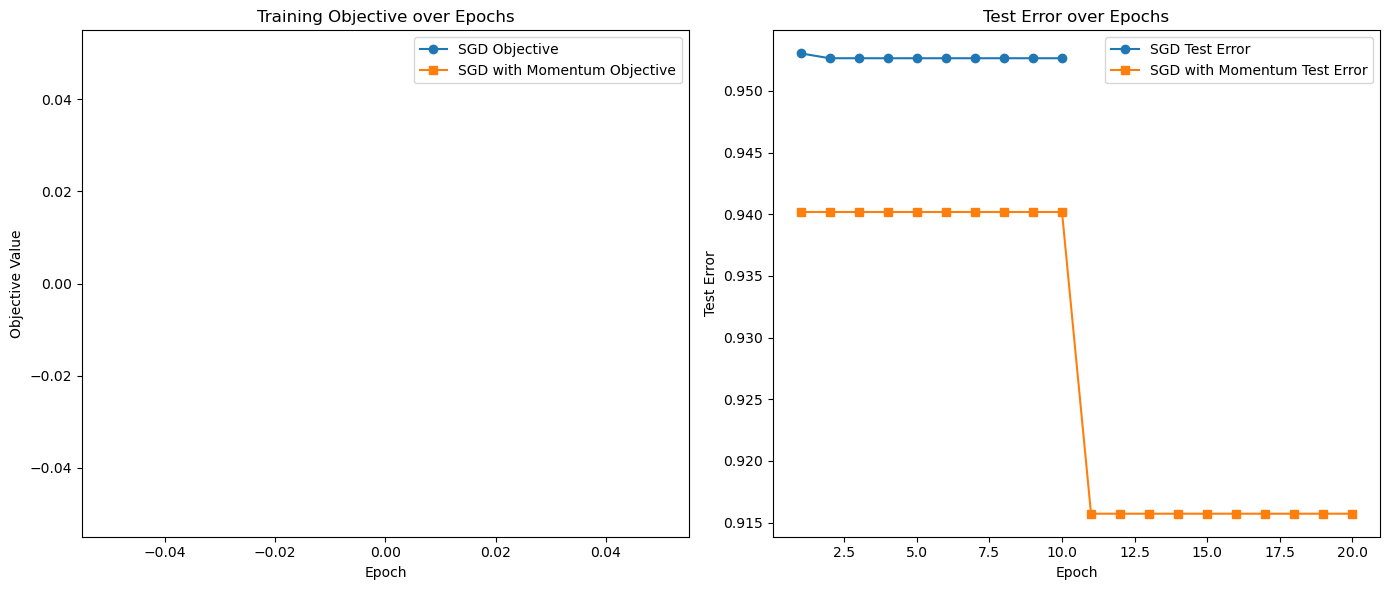

In [58]:
import matplotlib.pyplot as plt

def plot_optimization_comparison(sgd_obj_values, sgd_err_values,
                                 sgd_mom_obj_values, sgd_mom_err_values,
                                 lbfgs_obj_values, lbfgs_err_values):
    # Determine the maximum length among the provided lists to set x-axis correctly
    max_length = max(len(sgd_obj_values), len(sgd_mom_obj_values), len(lbfgs_obj_values) if lbfgs_obj_values else 0)

    epochs = range(1, max_length + 1)

    plt.figure(figsize=(14, 6))

    # Plotting training objectives
    plt.subplot(1, 2, 1)
    if sgd_obj_values:
        plt.plot(range(1, len(sgd_obj_values) + 1), sgd_obj_values, label='SGD Objective', marker='o')
    if sgd_mom_obj_values:
        plt.plot(range(1, len(sgd_mom_obj_values) + 1), sgd_mom_obj_values, label='SGD with Momentum Objective', marker='s')
    if lbfgs_obj_values:
        plt.plot(range(1, len(lbfgs_obj_values) + 1), lbfgs_obj_values, label='L-BFGS Objective', linestyle='--')
    plt.title('Training Objective over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Objective Value')
    plt.legend()

    # Plotting test errors
    plt.subplot(1, 2, 2)
    if sgd_err_values:
        plt.plot(range(1, len(sgd_err_values) + 1), sgd_err_values, label='SGD Test Error', marker='o')
    if sgd_mom_err_values:
        plt.plot(range(1, len(sgd_mom_err_values) + 1), sgd_mom_err_values, label='SGD with Momentum Test Error', marker='s')
    if lbfgs_err_values:
        plt.plot(range(1, len(lbfgs_err_values) + 1), lbfgs_err_values, label='L-BFGS Test Error', linestyle='--')
    plt.title('Test Error over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Test Error')
    plt.legend()

    plt.tight_layout()
    plt.show()


# Call the plotting function with your data
plot_optimization_comparison(sgd_objective_values, sgd_test_errors,
                             sgd_momentum_objective_values, sgd_momentum_test_errors,
                             lbfgs_objective_values, lbfgs_test_errors)
